In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:

learning_rate = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'learning_rate')
dropout_rate = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'dropout_rate')

#membership functions for learning rate
learning_rate['low'] = fuzz.trimf(learning_rate.universe, [0, 0, 0.5])
learning_rate['medium'] = fuzz.trimf(learning_rate.universe, [0, 0.5, 1])
learning_rate['high'] = fuzz.trimf(learning_rate.universe, [0.5, 1, 1])

dropout_rate['low'] = fuzz.trimf(dropout_rate.universe, [0, 0, 0.3])
dropout_rate['medium'] = fuzz.trimf(dropout_rate.universe, [0.2, 0.5, 0.8])
dropout_rate['high'] = fuzz.trimf(dropout_rate.universe, [0.7, 1, 1])

In [3]:

learning_rate_adjustment = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'learning_rate_adjustment')

learning_rate_adjustment['decrease'] = fuzz.trimf(learning_rate_adjustment.universe, [0, 0, 0.3])
learning_rate_adjustment['no_change'] = fuzz.trimf(learning_rate_adjustment.universe, [0.2, 0.5, 0.8])
learning_rate_adjustment['increase'] = fuzz.trimf(learning_rate_adjustment.universe, [0.7, 1, 1])

In [4]:
# fuzzy rules for adjusting learning rate
rule1 = ctrl.Rule(dropout_rate['low'], learning_rate_adjustment['increase'])
rule2 = ctrl.Rule(dropout_rate['medium'], learning_rate_adjustment['no_change'])
rule3 = ctrl.Rule(dropout_rate['high'], learning_rate_adjustment['decrease'])

learning_rate_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
learning_rate_adjustment_system = ctrl.ControlSystemSimulation(learning_rate_ctrl)

fuzzy_dropout_rate = 0.3

learning_rate_adjustment_system.input['dropout_rate'] = fuzzy_dropout_rate
learning_rate_adjustment_system.compute()

adjusted_learning_rate_value = learning_rate_adjustment_system.output['learning_rate_adjustment']

In [5]:
dataset_dir = 'ImageSet'
image_size = (224, 224)
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2623 images belonging to 4 classes.
Found 653 images belonging to 4 classes.


In [49]:
# Define CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(train_generator.num_classes, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=adjusted_learning_rate_value)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [50]:

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.1**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [51]:
num_epochs=20

history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.2968 - loss: 1.4046 - val_accuracy: 0.3798 - val_loss: 1.3276 - learning_rate: 0.0010
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.4016 - loss: 1.2989 - val_accuracy: 0.5528 - val_loss: 1.1785 - learning_rate: 7.9433e-04
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.5399 - loss: 1.0992 - val_accuracy: 0.5758 - val_loss: 1.0434 - learning_rate: 6.3096e-04
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5983 - loss: 0.9701 - val_accuracy: 0.6202 - val_loss: 0.9877 - learning_rate: 5.0119e-04
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6048 - loss: 0.9431 - val_accuracy: 0.5712 - val_loss: 1.0561 - learning_rate: 3.9811e-04
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6221 - loss: 0.9252 - val_accuracy: 0.6294 - val_loss: 0.9374 - learning_rate: 3.1623e-04
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.6657 - lo

In [52]:

model.save('fuzzy_model.h5')
print("Model saved.")

Model saved.


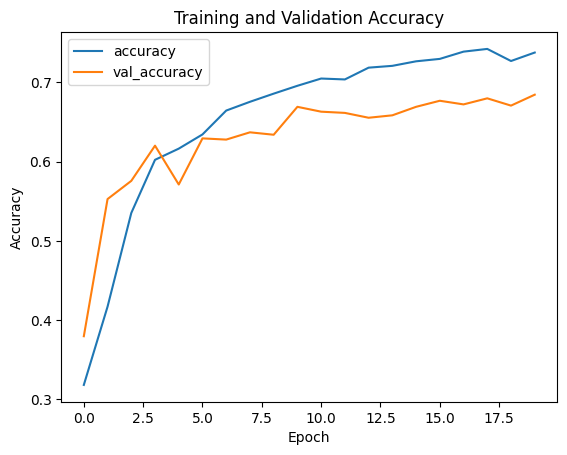

In [55]:

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



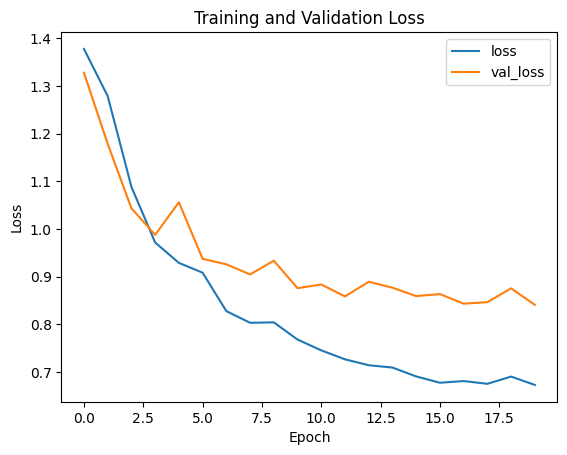

In [56]:
# Plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
def get_class(prediction):
    classes = ["Bus", "Car", "Motorcycle", "Truck"]
    return classes[np.argmax(prediction)]

In [59]:
import cv2
img = cv2.imread('test.png')
resize = tf.image.resize(img, (224, 224))
np.expand_dims(resize, 0)
prediction = model.predict(np.expand_dims(resize / 255, 0))

object_class = get_class(prediction[0])
confidence = np.max(prediction)

print(f"Predicted Object: {object_class}, Confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted Object: Car, Confidence: 0.5643569231033325


In [60]:
import os
import numpy as np
import cv2
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Assuming your model expects input size of 256x256
    image = image.astype('float32') / 255  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

test_image_folder = 'test_images'

class_labels = ['Bus', 'Car', 'Motorcycle', 'Truck'] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

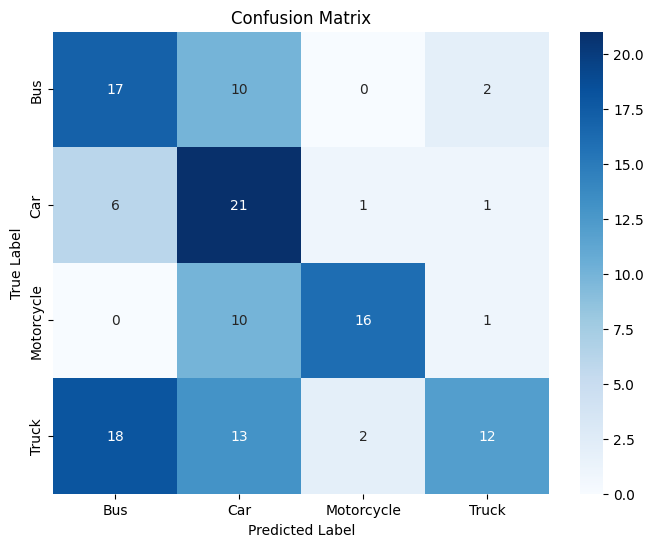

Class: Bus
Accuracy: 0.59
Recall: 0.59
F1 Score: 0.74

Class: Car
Accuracy: 0.72
Recall: 0.72
F1 Score: 0.84

Class: Motorcycle
Accuracy: 0.59
Recall: 0.59
F1 Score: 0.74

Class: Truck
Accuracy: 0.27
Recall: 0.27
F1 Score: 0.42

Overall Metrics:
Overall Accuracy: 0.51
Overall Precision: 0.61
Overall Recall: 0.51
Overall F1 Score: 0.50


In [61]:
precision_per_class = {}
accuracy_per_class = {}
recall_per_class = {}
f1_per_class = {}
predictions_all = []
ground_truth_all = []

for class_name in class_labels:
    class_folder = os.path.join(test_image_folder, class_name)
    test_images = os.listdir(class_folder)

    predictions_class = []
    ground_truth_class = [class_name] * len(test_images) 

    for image_name in test_images:
        image_path = os.path.join(class_folder, image_name)
        preprocessed_image = preprocess_image(image_path)
        predictions = model.predict(preprocessed_image)
        predicted_class = class_labels[np.argmax(predictions)]
        predictions_all.append(predicted_class)
        ground_truth_all.append(class_name)
        predictions_class.append(predicted_class)
    
    accuracy_per_class[class_name] = accuracy_score(ground_truth_class, predictions_class)
    precision_per_class[class_name] = precision_score(ground_truth_class, predictions_class, average='weighted', zero_division=1)
    recall_per_class[class_name] = recall_score(ground_truth_class, predictions_class, average='weighted', zero_division=1)
    f1_per_class[class_name] = f1_score(ground_truth_class, predictions_class, average='weighted', zero_division=1)

overall_accuracy = accuracy_score(ground_truth_all, predictions_all)
overall_precision = precision_score(ground_truth_all, predictions_all, average='weighted', zero_division=1)
overall_recall = recall_score(ground_truth_all, predictions_all, average='weighted', zero_division=1)
overall_f1 = f1_score(ground_truth_all, predictions_all, average='weighted', zero_division=1)

conf_matrix = confusion_matrix(ground_truth_all, predictions_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

for class_name in class_labels:
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[class_name]:.2f}")
    print(f"Recall: {recall_per_class[class_name]:.2f}")
    print(f"F1 Score: {f1_per_class[class_name]:.2f}")
    print()

print("Overall Metrics:")
print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1 Score: {overall_f1:.2f}")